In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import sys

sys.path.append("../../../analysisTools/")
import plotTools as ptools

In [2]:
# Initialize some dictionary that will later be used
signal_df = {} # yield
signal_match_df = {} # gen matched vtx

signal_reco_df = {} # yield only counting the events where gen ee are reconstructed
signal_match_reco_df = {} # gen matched vtx, out of the events where gen ee are reconstructed

for delta in ['0p1','0p2']:
    signal_df[delta] = {}
    signal_match_df[delta] = {}
    signal_reco_df[delta] = {}
    signal_match_reco_df[delta] = {}

In [3]:
sqrtBs = {'1': 0, '10': 0, '100': 0}

In [4]:
def plot_efficiency_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylim = [1e-5,5e-2], ylabel='Efficiency', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    cut = list(map(lambda x: x.replace('BDT v2 Loose WP', 'BDT Score'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    plt.ylim(ylim)
    
    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

In [5]:
def plot_counts_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylabel='Events', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    cut = list(map(lambda x: x.replace('BDT v2 Loose WP', 'BDT Score'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

## Ctau-1

### Import coffea files -- signal and background

In [6]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-1_5to50_skimmed'

In [7]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [8]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [9]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [10]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [11]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [12]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [13]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [14]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [15]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [16]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,0.033826,0.006982,0.005961,0.005695,0.005695,0.005695,0.005651,0.002804
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,0.014484,0.001842,0.001519,0.001421,0.001418,0.001418,0.001404,0.000677
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.014782,0.002143,0.001894,0.001811,0.001811,0.001811,0.001794,0.000660
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.036318,0.006259,0.005421,0.005217,0.005217,0.005217,0.005197,0.002280
sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,0.026904,0.005099,0.004306,0.004165,0.004161,0.004161,0.004135,0.002033
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.030555,0.005051,0.004338,0.004133,0.004127,0.004127,0.004103,0.001869
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,0.020878,0.003848,0.003369,0.003242,0.003235,0.003235,0.003195,0.001754
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.023214,0.003481,0.002980,0.002881,0.002881,0.002881,0.002855,0.001233
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,0.016920,0.002932,0.002531,0.002386,0.002386,0.002386,0.002357,0.001225
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.018942,0.002826,0.002381,0.002275,0.002273,0.002273,0.002253,0.000991


In [17]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [18]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [19]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,205.186408,42.353992,36.160985,34.547900,34.547900,34.547900,34.276942,17.007244
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,2748.241352,349.572905,288.308597,269.621849,268.976334,268.976334,266.400081,128.365134
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,62382.764516,9045.039685,7993.005413,7642.383575,7642.383575,7642.383575,7572.305104,2787.316093
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,6562.275287,1130.926755,979.542736,942.715841,942.715841,942.715841,939.115692,412.044822
sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,512.935117,97.210475,82.100675,79.402845,79.340009,79.340009,78.839199,38.762997
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,16193.175659,2676.895268,2298.731658,2190.267595,2187.083708,2187.083708,2174.327218,990.728036
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,49723.242758,9164.659073,8024.742583,7722.235274,7704.441742,7704.441742,7609.524639,4178.235083
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,33794.918905,5067.472655,4338.181148,4193.564237,4193.564237,4193.564237,4156.591358,1794.503944
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,995.446769,172.473503,148.909471,140.358362,140.358362,140.358362,138.674840,72.072975
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,30374.507403,4531.002909,3817.775056,3648.137891,3644.603971,3644.603971,3612.884287,1589.161260


In [20]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [21]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.599086,0.612185,0.625180,0.625180,0.625180,0.630122,0.984090
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.500157,0.516939,0.526463,0.527727,0.527727,0.530413,0.979881
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.422538,0.434271,0.438133,0.438133,0.438133,0.439877,0.974871
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.520468,0.531196,0.533386,0.533386,0.533386,0.533993,0.974913
sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,1.0,0.571031,0.587514,0.586940,0.586613,0.586613,0.587957,0.980599
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.504216,0.512162,0.513494,0.513512,0.513512,0.515058,0.971012
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.583515,0.585022,0.584129,0.584708,0.584708,0.587327,0.970185
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.477517,0.475646,0.474397,0.474397,0.474397,0.476192,0.968183
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.534935,0.544248,0.543458,0.543458,0.543458,0.546006,0.972771
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.479327,0.477280,0.483015,0.482514,0.482514,0.483828,0.966696


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [22]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [23]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [24]:
sig_eff_reco_df

,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,0.018895,0.007196,0.005871,0.017167,0.014365,0.014169,0.010975,0.010520,0.008736,0.008445,0.007452,0.006861
0 < n(jet) < 3 & n(good vertex) > 0,0.005339,0.001282,0.001300,0.004382,0.003796,0.003393,0.002956,0.002348,0.002138,0.001892,0.001548,0.001535
No b-tagged jets,0.004673,0.001078,0.001159,0.003842,0.003237,0.002944,0.002587,0.002031,0.001864,0.001590,0.001346,0.001296
Leading jet |eta| < 2.4,0.004540,0.001027,0.001121,0.003716,0.003132,0.002827,0.002485,0.001966,0.001756,0.001544,0.001282,0.001212
Leading jet pT > 80 GeV,0.004540,0.001027,0.001121,0.003716,0.003129,0.002821,0.002480,0.001966,0.001756,0.001542,0.001282,0.001212
"dPhi(MET,leading jet) > 1.5",0.004540,0.001027,0.001121,0.003716,0.003129,0.002821,0.002480,0.001966,0.001756,0.001542,0.001282,0.001212
"dPhi(MET,all jets) > 0.75",0.004495,0.001020,0.001113,0.003701,0.003106,0.002805,0.002457,0.001953,0.001742,0.001533,0.001276,0.001203
BDT v2 Loose WP,0.002759,0.000670,0.000660,0.002258,0.002013,0.001854,0.001732,0.001221,0.001223,0.000980,0.000839,0.000731


In [25]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [26]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [27]:
sig_cts_reco_df

,sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,sig_2018_Mchi-11p0_dMchi-2p0_ctau-1,sig_2018_Mchi-10p5_dMchi-1p0_ctau-1
Preselections,114.614464,1365.476804,24776.055248,3101.831764,273.875965,7508.961545,26139.124169,15314.917103,513.957969,13541.063436,705.454724,16968.666968
0 < n(jet) < 3 & n(good vertex) > 0,32.386537,243.181188,5486.757891,791.708021,72.375507,1797.940479,7038.875821,3417.531197,125.769029,3033.485521,146.561050,3796.110522
No b-tagged jets,28.346091,204.476061,4890.702896,694.246498,61.717310,1560.117606,6160.297188,2956.999665,109.642462,2549.684920,127.369315,3204.558647
Leading jet |eta| < 2.4,27.537828,194.806789,4732.804149,671.352937,59.709943,1497.937569,5917.129676,2862.763424,103.335736,2475.493613,121.396524,2996.709036
Leading jet pT > 80 GeV,27.537828,194.806789,4732.804149,671.352937,59.647115,1494.753860,5905.259315,2862.763424,103.335736,2471.959428,121.396524,2996.709036
"dPhi(MET,leading jet) > 1.5",27.537828,194.806789,4732.804149,671.352937,59.647115,1494.753860,5905.259315,2862.763424,103.335736,2471.959428,121.396524,2996.709036
"dPhi(MET,all jets) > 0.75",27.266874,193.518798,4697.843379,668.649776,59.208792,1486.781453,5851.900112,2842.585441,102.493126,2457.881697,120.757685,2975.416989
BDT v2 Loose WP,16.736664,127.074408,2787.316093,408.001326,38.387746,982.756605,4124.890517,1777.665582,71.933028,1571.503625,79.375994,1807.605719


In [28]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [29]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.783464,0.780961,0.784326,0.784326,0.784326,0.792120,1.000000
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.718975,0.728877,0.728650,0.728650,0.728650,0.730172,0.989834
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.696563,0.709741,0.707484,0.707484,0.707484,0.709024,0.974871
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.743470,0.749488,0.748982,0.748982,0.748982,0.749991,0.984575
sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,1.0,0.766975,0.781552,0.780519,0.780288,0.780288,0.782891,0.990185
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.750711,0.754638,0.750825,0.751358,0.751358,0.753241,0.978888
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.759740,0.762082,0.762326,0.762854,0.762854,0.763731,0.982732
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.708056,0.697816,0.694928,0.694928,0.694928,0.696315,0.977354
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.733584,0.739163,0.738166,0.738166,0.738166,0.738754,0.974663
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.715952,0.714657,0.711820,0.711408,0.711408,0.711188,0.977558


In [30]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1,1.0,0.599086,0.612185,0.625180,0.625180,0.625180,0.630122,0.984090
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1,1.0,0.500157,0.516939,0.526463,0.527727,0.527727,0.530413,0.979881
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,1.0,0.422538,0.434271,0.438133,0.438133,0.438133,0.439877,0.974871
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,1.0,0.520468,0.531196,0.533386,0.533386,0.533386,0.533993,0.974913
sig_2018_Mchi-44p0_dMchi-8p0_ctau-1,1.0,0.571031,0.587514,0.586940,0.586613,0.586613,0.587957,0.980599
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,1.0,0.504216,0.512162,0.513494,0.513512,0.513512,0.515058,0.971012
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1,1.0,0.583515,0.585022,0.584129,0.584708,0.584708,0.587327,0.970185
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1.0,0.477517,0.475646,0.474397,0.474397,0.474397,0.476192,0.968183
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1,1.0,0.534935,0.544248,0.543458,0.543458,0.543458,0.546006,0.972771
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1.0,0.479327,0.477280,0.483015,0.482514,0.482514,0.483828,0.966696


### Cutflow Dataframe -- background

In [31]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [32]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [33]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [34]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [35]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [36]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [37]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [38]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [39]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [40]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,1.294682e-04,1.126054e-05,6.373026e-04,0.001933,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,8.736155e-08,1.277478e-05,5.215843e-07,4.435487e-05,0.000158,1.729308e-04,3.983155e-04,1.258685e-06
No b-tagged jets,6.157029e-08,7.989828e-06,4.841556e-07,3.273392e-05,0.000104,1.387287e-04,3.251023e-04,1.005441e-06
Leading jet |eta| < 2.4,6.120635e-08,7.173793e-06,4.841556e-07,3.073427e-05,0.000092,1.315265e-04,3.095805e-04,9.577009e-07
Leading jet pT > 80 GeV,6.120635e-08,7.149992e-06,4.841556e-07,3.043376e-05,0.000091,1.312650e-04,3.090021e-04,9.559090e-07
"dPhi(MET,leading jet) > 1.5",6.117856e-08,7.149145e-06,4.841556e-07,3.029834e-05,0.000091,1.312209e-04,3.089645e-04,9.556166e-07
"dPhi(MET,all jets) > 0.75",2.933839e-08,6.716169e-06,3.539610e-07,2.727575e-05,0.000076,1.139098e-04,2.923517e-04,8.272960e-07
BDT v2 Loose WP,0.000000e+00,7.461726e-09,0.000000e+00,7.046273e-08,0.000000,2.391631e-07,3.544899e-07,1.387641e-09


In [41]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [42]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,1882.665324,559.218223,671.436619,307.914836,4.324318,17009.814573,8524.545695,28959.919588
No b-tagged jets,1326.856559,349.755962,623.254666,227.241343,2.854129,13645.628528,6957.674053,23133.265240
Leading jet |eta| < 2.4,1319.013605,314.033934,623.254666,213.359570,2.510261,12937.207075,6625.483327,22034.862439
Leading jet pT > 80 GeV,1319.013605,312.992040,623.254666,211.273431,2.506022,12911.488177,6613.106470,21993.634411
"dPhi(MET,leading jet) > 1.5",1318.414646,312.954947,623.254666,210.333328,2.501784,12907.145737,6612.301368,21986.906477
"dPhi(MET,all jets) > 0.75",632.250399,294.001347,455.654738,189.350279,2.086892,11204.390252,6256.761468,19034.495374
BDT v2 Loose WP,0.000000,0.326638,0.000000,0.489158,0.000000,23.524556,7.586612,31.926964


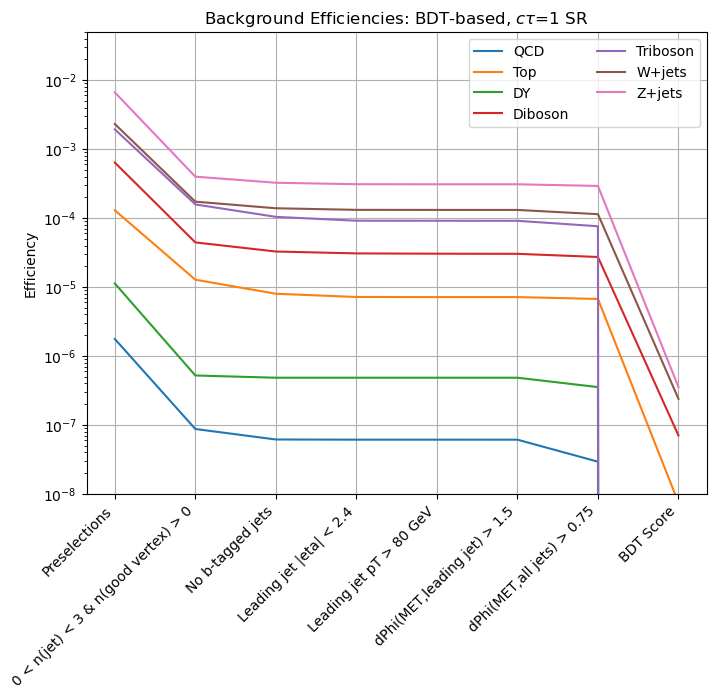

<Figure size 640x480 with 0 Axes>

In [43]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title(r"Background Efficiencies: BDT-based, $c\tau$=1 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
cut = list(map(lambda x: x.replace('BDT v2 Loose WP', 'BDT Score'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
plt.savefig(f"plots/bkg_BDT-ctau1_combined_efficiencies.png")

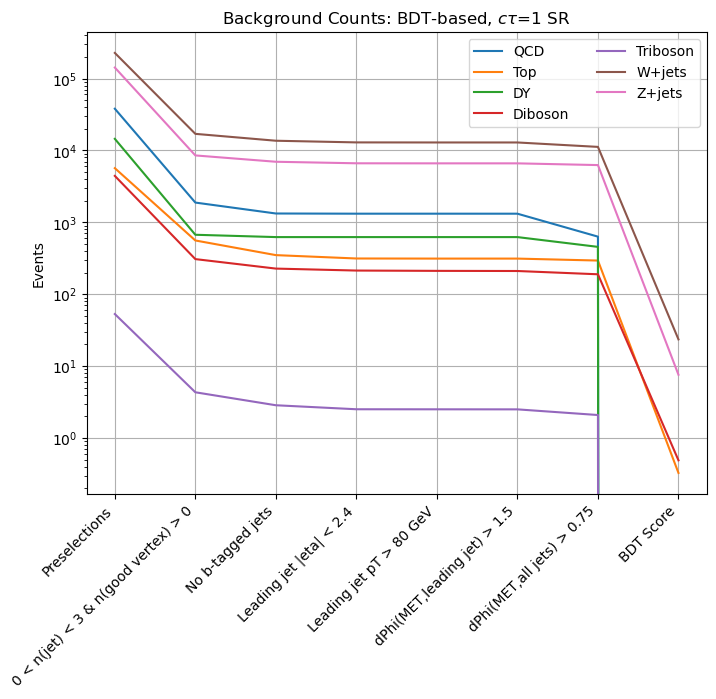

In [44]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title(r"Background Counts: BDT-based, $c\tau$=1 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_cts[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Events")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
cut = list(map(lambda x: x.replace('BDT v2 Loose WP', 'BDT Score'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

#plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
#plt.savefig(f"plots/bkg_BDT-ctau1_combined_efficiencies.png")

### Bkg Yield

In [45]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 31.93
sqrt(B) = 5.65


In [46]:
sqrtBs['1'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [47]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [48]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '1'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-1', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-1', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-1']


In [49]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['1']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [50]:
print('Signal yield for delta = 0.1, ctau = 1')
signal_df['0p1']['1'].transpose()

Signal yield for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,1839.613547
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1589.161260
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1794.503944
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,990.728036
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,412.044822
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,2787.316093


In [51]:
print('Vertex purity for delta = 0.1, ctau = 1')
signal_match_df['0p1']['1'].transpose()

Vertex purity for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,0.950705
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.966696
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.968183
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.971012
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.974913
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.974871


In [52]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['1']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [53]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1')
signal_reco_df['0p1']['1'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,1807.605719
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,1571.503625
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,1777.665582
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,982.756605
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,408.001326
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,2787.316093


In [54]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1')
signal_match_reco_df['0p1']['1'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 1


,1mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1,0.967539
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1,0.977558
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1,0.977354
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1,0.978888
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1,0.984575
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1,0.974871


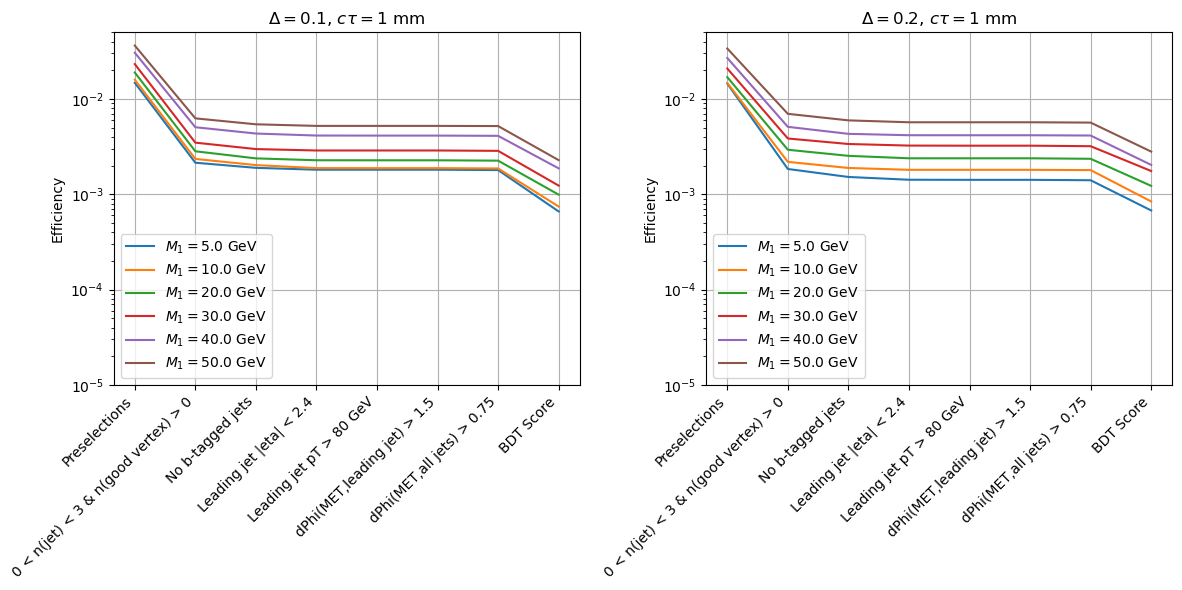

In [55]:
deltas = [0.1,0.2]

ct = 1

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Ctau-10

### Import coffea files -- signal and background

In [56]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-10_5to50_skimmed'

In [57]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [58]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [59]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [60]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [61]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [62]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [63]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [64]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [65]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
cut = list(map(lambda x: x.replace('BDT v2 Loose WP', 'BDT Loose WP'), cut))


sig_eff_df.index = cut

In [66]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,0.010930,0.001187,0.000987,0.000935,0.000931,0.000931,0.000876,0.000235
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,0.031125,0.005252,0.004562,0.004329,0.004329,0.004329,0.004260,0.002026
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.010676,0.001022,0.000847,0.000792,0.000792,0.000792,0.000771,0.000147
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.032445,0.004564,0.003903,0.003752,0.003752,0.003752,0.003708,0.001414
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.025875,0.003520,0.003022,0.002902,0.002902,0.002902,0.002875,0.001118
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,0.019309,0.002550,0.002202,0.002122,0.002120,0.002120,0.002075,0.000990
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,0.024702,0.003809,0.003226,0.003090,0.003090,0.003090,0.003027,0.001360
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.020128,0.002757,0.002373,0.002303,0.002301,0.002301,0.002280,0.000865
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.016286,0.001989,0.001734,0.001669,0.001669,0.001669,0.001649,0.000515
sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,0.012593,0.001410,0.001150,0.001083,0.001083,0.001083,0.001046,0.000354


In [67]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [68]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [69]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,211.621136,22.976276,19.101673,18.099530,18.033157,18.033157,16.965408,4.543953
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,18.964345,3.200085,2.779586,2.637744,2.637744,2.637744,2.595839,1.234690
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,6090.241352,583.268175,483.383984,451.729326,451.729326,451.729326,439.550936,84.007888
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,625.950369,88.057684,75.299194,72.378771,72.378771,72.378771,71.542770,27.287742
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1569.133425,213.483994,183.289395,176.009913,176.009913,176.009913,174.341026,67.818152
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,15555.452101,2054.322570,1773.838230,1709.695777,1707.690425,1707.690425,1671.585091,797.807828
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,47.304640,7.295161,6.178194,5.917338,5.917338,5.917338,5.797324,2.603764
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,27263.502227,3734.673787,3214.536713,3119.890211,3117.259784,3117.259784,3088.326520,1171.794549
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,3043.716823,371.803097,324.157435,312.003112,312.003112,312.003112,308.264550,96.233563
sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,118.479518,13.269842,10.814831,10.192790,10.192790,10.192790,9.839573,3.330175


In [70]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [71]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.296610,0.314809,0.306420,0.307548,0.307548,0.322959,0.941216
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.537021,0.548269,0.549837,0.549837,0.549837,0.558713,0.987220
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.265125,0.284620,0.288401,0.288401,0.288401,0.290839,0.883988
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.456355,0.448635,0.451998,0.451998,0.451998,0.453389,0.977909
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.438500,0.446179,0.453428,0.453428,0.453428,0.454287,0.973147
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.503462,0.510812,0.517052,0.517659,0.517659,0.520439,0.987457
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.502103,0.508406,0.512306,0.512306,0.512306,0.520219,0.975969
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.412978,0.420965,0.426144,0.425660,0.425660,0.427091,0.975273
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.358085,0.357367,0.351811,0.351811,0.351811,0.354561,0.941807
sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,1.0,0.363771,0.363912,0.367979,0.367979,0.367979,0.377762,0.969699


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [72]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [73]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [74]:
sig_eff_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10
Preselections,0.002953,0.013324,0.002087,0.011383,0.009238,0.007543,0.010259,0.006725,0.004959,0.004207,0.005956,0.003264
0 < n(jet) < 3 & n(good vertex) > 0,0.000521,0.003597,0.000420,0.002751,0.002102,0.001655,0.002417,0.001519,0.001032,0.000765,0.001176,0.000693
No b-tagged jets,0.000445,0.003148,0.000369,0.002338,0.001814,0.001441,0.002054,0.001308,0.000887,0.000627,0.001025,0.000589
Leading jet |eta| < 2.4,0.000421,0.003001,0.000350,0.002263,0.001767,0.001403,0.001989,0.001284,0.000850,0.000597,0.000979,0.000564
Leading jet pT > 80 GeV,0.000421,0.003001,0.000350,0.002263,0.001767,0.001403,0.001989,0.001282,0.000850,0.000597,0.000979,0.000564
"dPhi(MET,leading jet) > 1.5",0.000421,0.003001,0.000350,0.002263,0.001767,0.001403,0.001989,0.001282,0.000850,0.000597,0.000979,0.000564
"dPhi(MET,all jets) > 0.75",0.000404,0.002958,0.000339,0.002234,0.001754,0.001376,0.001959,0.001277,0.000842,0.000590,0.000960,0.000552
BDT v2 Loose WP,0.000228,0.002009,0.000141,0.001400,0.001103,0.000988,0.001349,0.000861,0.000500,0.000350,0.000668,0.000298


In [75]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [76]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [77]:
sig_cts_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,sig_2018_Mchi-22p0_dMchi-4p0_ctau-10,sig_2018_Mchi-10p5_dMchi-1p0_ctau-10
Preselections,57.180228,8.118168,1190.665743,219.612491,560.229583,6077.058542,19.646746,9108.794445,926.846150,39.578707,35.351179,942.926858
0 < n(jet) < 3 & n(good vertex) > 0,10.088073,2.191445,239.882501,53.079174,127.453176,1332.950630,4.628290,2057.511851,192.901624,7.198891,6.982371,200.260840
No b-tagged jets,8.618702,1.918127,210.620371,45.099587,110.008161,1160.672436,3.934190,1771.216758,165.806615,5.903361,6.085103,170.168770
Leading jet |eta| < 2.4,8.151389,1.828723,199.669941,43.662325,107.127099,1130.570090,3.808996,1739.634497,158.798775,5.617535,5.812612,162.991234
Leading jet pT > 80 GeV,8.151389,1.828723,199.669941,43.662325,107.127099,1130.570090,3.808996,1737.003785,158.798775,5.617535,5.812612,162.991234
"dPhi(MET,leading jet) > 1.5",8.151389,1.828723,199.669941,43.662325,107.127099,1130.570090,3.808996,1737.003785,158.798775,5.617535,5.812612,162.991234
"dPhi(MET,all jets) > 0.75",7.816946,1.802543,193.575064,43.105379,106.368538,1108.501708,3.751665,1729.109791,157.395984,5.550187,5.699044,159.398524
BDT v2 Loose WP,4.410148,1.224196,80.348722,27.009639,66.908321,795.806789,2.582899,1166.521911,93.430809,3.296574,3.961948,86.209302


In [78]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [79]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.675550,0.697712,0.680382,0.680382,0.680382,0.700929,0.969773
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.784191,0.794504,0.793083,0.793083,0.793083,0.804601,0.995682
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.644644,0.653216,0.652473,0.652473,0.652473,0.660408,0.924246
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.757087,0.749050,0.749274,0.749274,0.749274,0.752498,0.987978
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.734488,0.743399,0.744983,0.744983,0.744983,0.744590,0.986380
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.775928,0.780667,0.781908,0.781908,0.781908,0.784805,0.989940
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.791420,0.798393,0.795876,0.795876,0.795876,0.803877,0.983854
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.749614,0.763998,0.764254,0.763897,0.763897,0.762819,0.979682
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.690181,0.698664,0.691227,0.691227,0.691227,0.694417,0.970060
sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,1.0,0.670545,0.666679,0.667683,0.667683,0.667683,0.669710,0.979583


In [80]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10,1.0,0.296610,0.314809,0.306420,0.307548,0.307548,0.322959,0.941216
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10,1.0,0.537021,0.548269,0.549837,0.549837,0.549837,0.558713,0.987220
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,1.0,0.265125,0.284620,0.288401,0.288401,0.288401,0.290839,0.883988
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,1.0,0.456355,0.448635,0.451998,0.451998,0.451998,0.453389,0.977909
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,1.0,0.438500,0.446179,0.453428,0.453428,0.453428,0.454287,0.973147
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10,1.0,0.503462,0.510812,0.517052,0.517659,0.517659,0.520439,0.987457
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10,1.0,0.502103,0.508406,0.512306,0.512306,0.512306,0.520219,0.975969
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1.0,0.412978,0.420965,0.426144,0.425660,0.425660,0.427091,0.975273
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,1.0,0.358085,0.357367,0.351811,0.351811,0.351811,0.354561,0.941807
sig_2018_Mchi-11p0_dMchi-2p0_ctau-10,1.0,0.363771,0.363912,0.367979,0.367979,0.367979,0.377762,0.969699


### Cutflow Dataframe -- background

In [81]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [82]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [83]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [84]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [85]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [86]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [87]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [88]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [89]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [90]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,1.294682e-04,1.126054e-05,6.373026e-04,0.001933,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,8.736155e-08,1.277478e-05,5.215843e-07,4.435487e-05,0.000158,1.729308e-04,3.983155e-04,1.258685e-06
No b-tagged jets,6.157029e-08,7.989828e-06,4.841556e-07,3.273392e-05,0.000104,1.387287e-04,3.251023e-04,1.005441e-06
Leading jet |eta| < 2.4,6.120635e-08,7.173793e-06,4.841556e-07,3.073427e-05,0.000092,1.315265e-04,3.095805e-04,9.577009e-07
Leading jet pT > 80 GeV,6.120635e-08,7.149992e-06,4.841556e-07,3.043376e-05,0.000091,1.312650e-04,3.090021e-04,9.559090e-07
"dPhi(MET,leading jet) > 1.5",6.117856e-08,7.149145e-06,4.841556e-07,3.029834e-05,0.000091,1.312209e-04,3.089645e-04,9.556166e-07
"dPhi(MET,all jets) > 0.75",2.933839e-08,6.716169e-06,3.539610e-07,2.727575e-05,0.000076,1.139098e-04,2.923517e-04,8.272960e-07
BDT v2 Loose WP,0.000000e+00,5.767040e-09,0.000000e+00,4.192895e-08,0.000000,5.666668e-08,1.083628e-07,3.666755e-10


In [91]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [92]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,1882.665324,559.218223,671.436619,307.914836,4.324318,17009.814573,8524.545695,28959.919588
No b-tagged jets,1326.856559,349.755962,623.254666,227.241343,2.854129,13645.628528,6957.674053,23133.265240
Leading jet |eta| < 2.4,1319.013605,314.033934,623.254666,213.359570,2.510261,12937.207075,6625.483327,22034.862439
Leading jet pT > 80 GeV,1319.013605,312.992040,623.254666,211.273431,2.506022,12911.488177,6613.106470,21993.634411
"dPhi(MET,leading jet) > 1.5",1318.414646,312.954947,623.254666,210.333328,2.501784,12907.145737,6612.301368,21986.906477
"dPhi(MET,all jets) > 0.75",632.250399,294.001347,455.654738,189.350279,2.086892,11204.390252,6256.761468,19034.495374
BDT v2 Loose WP,0.000000,0.252453,0.000000,0.291074,0.000000,5.573847,2.319126,8.436500


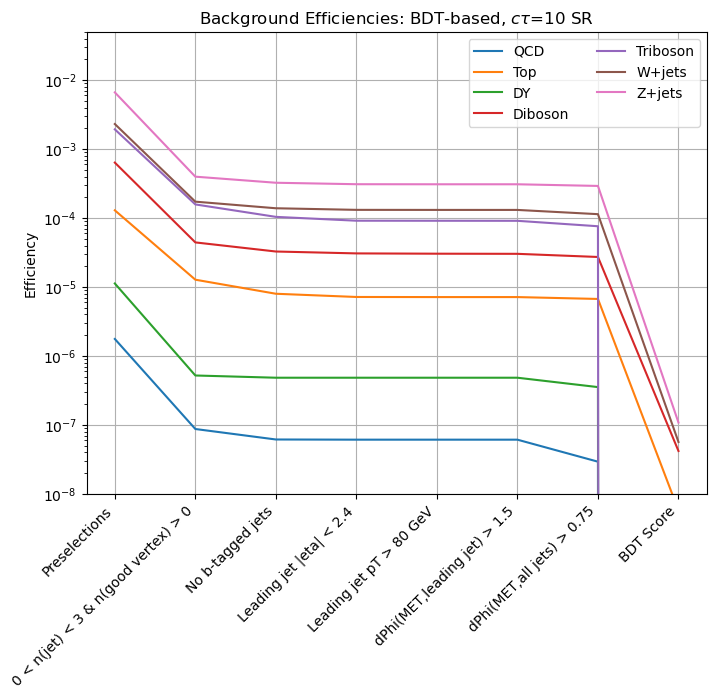

<Figure size 640x480 with 0 Axes>

In [93]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title(r"Background Efficiencies: BDT-based, $c\tau$=10 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
cut = list(map(lambda x: x.replace('BDT v2 Loose WP', 'BDT Score'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
plt.savefig(f"plots/bkg_BDT-ctau10_combined_efficiencies.png")

### Bkg Yield

In [94]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 8.44
sqrt(B) = 2.90


In [95]:
sqrtBs['10'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [96]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [97]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '10'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-10', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-10', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-10']


In [98]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['10']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [99]:
print('Signal yield for delta = 0.1, ctau = 10')
signal_df['0p1']['10'].transpose()

Signal yield for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,88.454491
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,96.233563
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1171.794549
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,67.818152
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,27.287742
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,84.007888


In [100]:
print('Vertex purity for delta = 0.1, ctau = 10')
signal_match_df['0p1']['10'].transpose()

Vertex purity for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,0.959399
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.941807
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.975273
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.973147
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.977909
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.883988


In [101]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['10']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [102]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10')
signal_reco_df['0p1']['10'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,86.209302
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,93.430809
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,1166.521911
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,66.908321
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,27.009639
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,80.348722


In [103]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10')
signal_match_reco_df['0p1']['10'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 10


,10mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10,0.984385
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10,0.970060
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10,0.979682
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10,0.986380
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10,0.987978
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10,0.924246


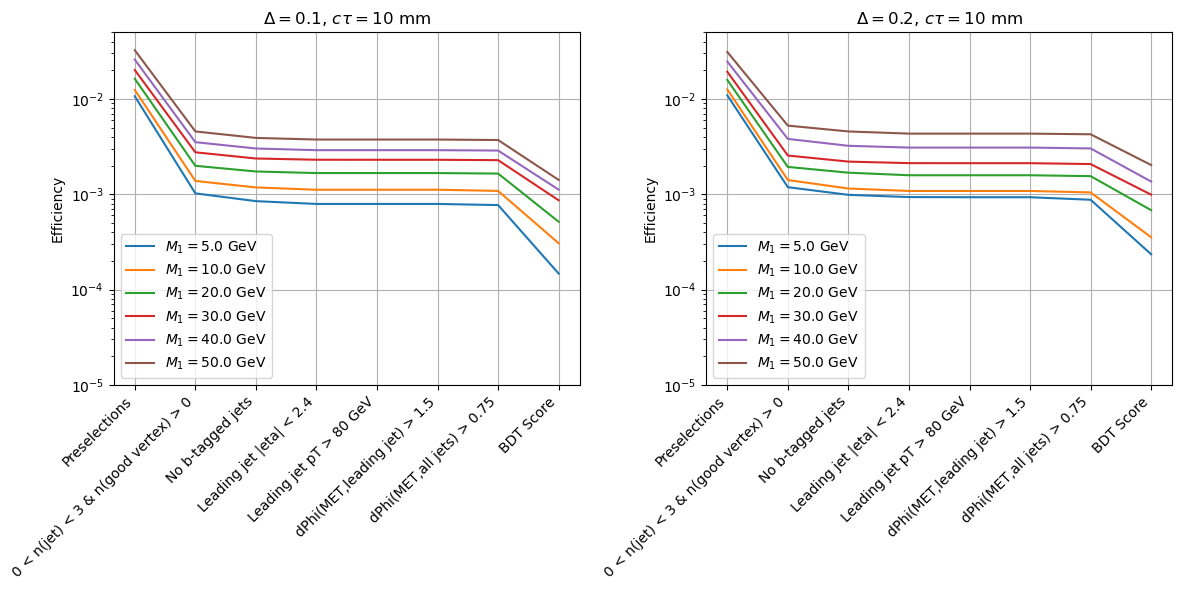

In [104]:
deltas = [0.1,0.2]

ct = 10

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Ctau-100

### Import coffea files -- signal and background

In [105]:
prefix = './coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-100_5to50_skimmed'

In [106]:
# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

In [107]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

### Cutflow Dataframe -- signal

In [108]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

In [109]:
# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

In [110]:
# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

In [111]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

In [112]:
deltas = sorted(list(set(si.delta)))

#### For signal events

In [113]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

In [114]:
sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [115]:
sig_eff_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,0.007414,0.000647,0.000562,0.000528,0.000528,0.000528,0.000501,0.000051
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.007306,0.000596,0.000504,0.000475,0.000475,0.000475,0.000457,0.000032
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,0.022439,0.002420,0.002063,0.001980,0.001980,0.001980,0.001893,0.000504
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.022522,0.002231,0.001905,0.001847,0.001847,0.001847,0.001804,0.000412
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,0.013585,0.001285,0.001082,0.001052,0.001052,0.001052,0.001011,0.000228
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,0.017576,0.001802,0.001476,0.001411,0.001411,0.001411,0.001364,0.000344
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.017664,0.001657,0.001419,0.001371,0.001371,0.001371,0.001331,0.000303
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.013536,0.001197,0.001041,0.000995,0.000995,0.000995,0.000966,0.000177
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,0.010335,0.000922,0.000793,0.000760,0.000760,0.000760,0.000722,0.000162
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.010649,0.000928,0.000818,0.000775,0.000775,0.000775,0.000749,0.000111


In [116]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

In [117]:
sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [118]:
sig_cts_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,14.287467,1.246745,1.082620,1.017052,1.017052,1.017052,0.964478,0.098396
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,443.657710,36.186419,30.606686,28.817702,28.817702,28.817702,27.734501,1.915313
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.367489,0.147453,0.125749,0.120663,0.120663,0.120663,0.115385,0.030711
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,43.757275,4.335275,3.701598,3.588904,3.588904,3.588904,3.504454,0.800294
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1302.773429,123.246286,103.804582,100.854231,100.854231,100.854231,96.920244,21.898237
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,3.352116,0.343599,0.281474,0.269112,0.269112,0.269112,0.260240,0.065606
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,108.825066,10.209122,8.740354,8.445451,8.445451,8.445451,8.197402,1.864469
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,24707.114125,2184.597749,1899.409931,1816.958888,1816.958888,1816.958888,1763.830603,322.907075
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,6.142378,0.548201,0.471416,0.451724,0.451724,0.451724,0.429092,0.096455
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,200.845707,17.499996,15.419565,14.610412,14.610412,14.610412,14.120705,2.084500


In [119]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [120]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.094778,0.103057,0.103253,0.103253,0.103253,0.102060,0.933654
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.082836,0.082989,0.083810,0.083810,0.083810,0.084089,0.913109
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.281222,0.292453,0.298292,0.298292,0.298292,0.311935,0.955395
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.242447,0.251210,0.248896,0.248896,0.248896,0.252486,0.957745
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.225522,0.227500,0.234155,0.234155,0.234155,0.241132,0.910162
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.252725,0.271336,0.268495,0.268495,0.268495,0.273995,0.942012
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.224672,0.229426,0.231098,0.231098,0.231098,0.236464,0.960489
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.182426,0.179953,0.180549,0.180549,0.180549,0.185987,0.899046
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.213699,0.217179,0.217925,0.217925,0.217925,0.227127,0.918445
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.140124,0.138395,0.144374,0.144374,0.144374,0.149381,0.929322


#### For signal events having gen ee reconstructed (having reco e with dR < 0.1)

In [121]:
sig_columns_reco = list(cf_s_reco.keys())
sig_efficiency_reco = {c: [ cf_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}
sig_match_reco = {c: [ fr_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [122]:
sig_eff_reco_df = pd.DataFrame.from_dict(sig_efficiency_reco).transpose()
sig_eff_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_reco_df.index = cut

In [123]:
sig_eff_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100
Preselections,0.000429,0.000304,0.004794,0.003601,0.002362,0.003440,0.002571,0.001752,0.001522,0.001148,0.000807,0.000555
0 < n(jet) < 3 & n(good vertex) > 0,0.000089,0.000076,0.000979,0.000744,0.000413,0.000650,0.000516,0.000323,0.000263,0.000200,0.000137,0.000111
No b-tagged jets,0.000075,0.000066,0.000854,0.000640,0.000356,0.000557,0.000444,0.000279,0.000235,0.000177,0.000117,0.000096
Leading jet |eta| < 2.4,0.000071,0.000062,0.000828,0.000619,0.000354,0.000532,0.000433,0.000269,0.000225,0.000172,0.000116,0.000089
Leading jet pT > 80 GeV,0.000071,0.000062,0.000828,0.000619,0.000354,0.000532,0.000433,0.000269,0.000225,0.000172,0.000116,0.000089
"dPhi(MET,leading jet) > 1.5",0.000071,0.000062,0.000828,0.000619,0.000354,0.000532,0.000433,0.000269,0.000225,0.000172,0.000116,0.000089
"dPhi(MET,all jets) > 0.75",0.000068,0.000060,0.000819,0.000608,0.000351,0.000523,0.000427,0.000267,0.000224,0.000170,0.000115,0.000089
BDT v2 Loose WP,0.000048,0.000029,0.000494,0.000405,0.000218,0.000327,0.000295,0.000165,0.000151,0.000105,0.000070,0.000057


In [124]:
sig_counts_reco = {c: [ ct_s_reco[samp][c] for samp in sig_columns_reco ] for c in cuts}

In [125]:
sig_cts_reco_df = pd.DataFrame.from_dict(sig_counts_reco).transpose()
sig_cts_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_reco_df.index = cut

In [126]:
sig_cts_reco_df

,sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,sig_2018_Mchi-11p0_dMchi-2p0_ctau-100,sig_2018_Mchi-10p5_dMchi-1p0_ctau-100
Preselections,0.827147,18.447519,0.292147,6.996573,226.543326,0.656124,15.842030,3197.567008,0.904543,21.643236,0.768680,16.484894
0 < n(jet) < 3 & n(good vertex) > 0,0.170568,4.621960,0.059656,1.445372,39.597849,0.123910,3.178924,589.243103,0.156517,3.775849,0.130093,3.281567
No b-tagged jets,0.144298,3.997833,0.052033,1.242540,34.186905,0.106166,2.736123,508.479077,0.139785,3.335222,0.111867,2.837542
Leading jet |eta| < 2.4,0.137740,3.789926,0.050466,1.203100,33.942837,0.101412,2.669171,491.290695,0.133874,3.237193,0.110572,2.644603
Leading jet pT > 80 GeV,0.137740,3.789926,0.050466,1.203100,33.942837,0.101412,2.669171,491.290695,0.133874,3.237193,0.110572,2.644603
"dPhi(MET,leading jet) > 1.5",0.137740,3.789926,0.050466,1.203100,33.942837,0.101412,2.669171,491.290695,0.133874,3.237193,0.110572,2.644603
"dPhi(MET,all jets) > 0.75",0.131161,3.665276,0.049881,1.180574,33.697929,0.099828,2.629015,487.870376,0.132890,3.212631,0.109275,2.644603
BDT v2 Loose WP,0.091868,1.790401,0.030125,0.786222,20.913904,0.062436,1.817663,300.621085,0.089574,1.986437,0.066348,1.679269


In [127]:
sig_match_reco_df = pd.DataFrame.from_dict(sig_match_reco).transpose()
sig_match_reco_df.columns = sig_columns_reco

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_reco_df.index = cut

In [128]:
sig_match_reco_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.692768,0.773201,0.762403,0.762403,0.762403,0.750484,1.000000
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.648542,0.635350,0.637269,0.637269,0.637269,0.636290,0.976814
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.695102,0.706778,0.713199,0.713199,0.713199,0.721573,0.973993
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.727200,0.748368,0.742469,0.742469,0.742469,0.749489,0.974888
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.701924,0.690777,0.695744,0.695744,0.695744,0.693533,0.952999
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.700802,0.719380,0.712489,0.712489,0.712489,0.714271,0.989837
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.721535,0.732885,0.731210,0.731210,0.731210,0.737306,0.985222
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.676338,0.672208,0.667731,0.667731,0.667731,0.672413,0.965695
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.748479,0.732424,0.735335,0.735335,0.735335,0.733376,0.988999
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.649434,0.639836,0.651602,0.651602,0.651602,0.656584,0.975199


In [129]:
sig_match_df.transpose()

,Preselections,0 < n(jet) < 3 & n(good vertex) > 0,No b-tagged jets,Leading jet |eta| < 2.4,Leading jet pT > 80 GeV,"dPhi(MET,leading jet) > 1.5","dPhi(MET,all jets) > 0.75",BDT v2 Loose WP
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100,1.0,0.094778,0.103057,0.103253,0.103253,0.103253,0.102060,0.933654
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.0,0.082836,0.082989,0.083810,0.083810,0.083810,0.084089,0.913109
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100,1.0,0.281222,0.292453,0.298292,0.298292,0.298292,0.311935,0.955395
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,1.0,0.242447,0.251210,0.248896,0.248896,0.248896,0.252486,0.957745
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100,1.0,0.225522,0.227500,0.234155,0.234155,0.234155,0.241132,0.910162
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100,1.0,0.252725,0.271336,0.268495,0.268495,0.268495,0.273995,0.942012
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.0,0.224672,0.229426,0.231098,0.231098,0.231098,0.236464,0.960489
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,1.0,0.182426,0.179953,0.180549,0.180549,0.180549,0.185987,0.899046
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100,1.0,0.213699,0.217179,0.217925,0.217925,0.217925,0.227127,0.918445
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.0,0.140124,0.138395,0.144374,0.144374,0.144374,0.149381,0.929322


### Cutflow Dataframe -- background

In [130]:
cuts = list(bkg_histos['W+jets']['cutflow']['bkg_2018_WJetsLNu_HT2500toInf'])

In [131]:
tot_bkg_cts = {} 
tot_bkg_effs = {} 
total_bkg_counts = {} 

In [132]:
for b in bkg_histos.keys():
    
    total_bkg_counts[b] = 0
    for k in bkg_histos[b]['cutflow'].keys():
        total_bkg_counts[b] += bkg_histos[b]['cutflow_cts'][k]['all'] / bkg_histos[b]['cutflow'][k]['all']

In [133]:
for b in bkg_histos.keys():
    cfd = bkg_histos[b]['cutflow_cts']
    effd = bkg_histos[b]['cutflow']

    cts_dict = {k:0 for k in cuts}
    
    for k in cfd.keys():
        for c in cuts:
            cts_dict[c] += cfd[k][c]

    tot_bkg_cts[b] = cts_dict # subprocess summed
    tot_bkg_effs[b] = {c:cts_dict[c]/total_bkg_counts[b] for c in cuts}

In [134]:
bkg_summed_cts = {c:sum([tot_bkg_cts[b][c] for b in tot_bkg_cts.keys()]) for c in cuts}

In [135]:
bkg_summed_eff = {c: bkg_summed_cts[c] / sum(total_bkg_counts.values()) for c in cuts}

In [136]:
bkg_columns = list(bkg_histos.keys())
bkg_columns.append('total')

tot_bkg_effs['total'] = bkg_summed_eff
tot_bkg_cts['total'] = bkg_summed_cts

In [137]:
bkg_efficiency = {c: [ tot_bkg_effs[samp][c] for samp in bkg_columns ] for c in cuts}
bkg_counts = {c: [ tot_bkg_cts[samp][c] for samp in bkg_columns ] for c in cuts}

In [138]:
bkg_eff_df = pd.DataFrame.from_dict(bkg_efficiency).transpose()
bkg_eff_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_eff_df.index = cut

In [139]:
bkg_eff_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,1.765167e-06,0.000129,1.126054e-05,6.373026e-04,0.001933,2.309964e-03,6.645339e-03,1.878092e-05
0 < n(jet) < 3 & n(good vertex) > 0,8.736155e-08,0.000013,5.215843e-07,4.435487e-05,0.000158,1.729308e-04,3.983155e-04,1.258685e-06
No b-tagged jets,6.157029e-08,0.000008,4.841556e-07,3.273392e-05,0.000104,1.387287e-04,3.251023e-04,1.005441e-06
Leading jet |eta| < 2.4,6.120635e-08,0.000007,4.841556e-07,3.073427e-05,0.000092,1.315265e-04,3.095805e-04,9.577009e-07
Leading jet pT > 80 GeV,6.120635e-08,0.000007,4.841556e-07,3.043376e-05,0.000091,1.312650e-04,3.090021e-04,9.559090e-07
"dPhi(MET,leading jet) > 1.5",6.117856e-08,0.000007,4.841556e-07,3.029834e-05,0.000091,1.312209e-04,3.089645e-04,9.556166e-07
"dPhi(MET,all jets) > 0.75",2.933839e-08,0.000007,3.539610e-07,2.727575e-05,0.000076,1.139098e-04,2.923517e-04,8.272960e-07
BDT v2 Loose WP,0.000000e+00,0.000000,0.000000e+00,4.192895e-08,0.000000,4.809060e-08,8.572746e-08,2.979847e-10


In [140]:
bkg_cts_df = pd.DataFrame.from_dict(bkg_counts).transpose()
bkg_cts_df.columns = bkg_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

bkg_cts_df.index = cut

In [141]:
bkg_cts_df

,QCD,Top,DY,Diboson,Triboson,W+jets,Z+jets,total
Preselections,38039.826987,5667.491120,14495.724273,4424.202428,52.996922,227212.601036,142220.153499,432112.996264
0 < n(jet) < 3 & n(good vertex) > 0,1882.665324,559.218223,671.436619,307.914836,4.324318,17009.814573,8524.545695,28959.919588
No b-tagged jets,1326.856559,349.755962,623.254666,227.241343,2.854129,13645.628528,6957.674053,23133.265240
Leading jet |eta| < 2.4,1319.013605,314.033934,623.254666,213.359570,2.510261,12937.207075,6625.483327,22034.862439
Leading jet pT > 80 GeV,1319.013605,312.992040,623.254666,211.273431,2.506022,12911.488177,6613.106470,21993.634411
"dPhi(MET,leading jet) > 1.5",1318.414646,312.954947,623.254666,210.333328,2.501784,12907.145737,6612.301368,21986.906477
"dPhi(MET,all jets) > 0.75",632.250399,294.001347,455.654738,189.350279,2.086892,11204.390252,6256.761468,19034.495374
BDT v2 Loose WP,0.000000,0.000000,0.000000,0.291074,0.000000,4.730287,1.834695,6.856057


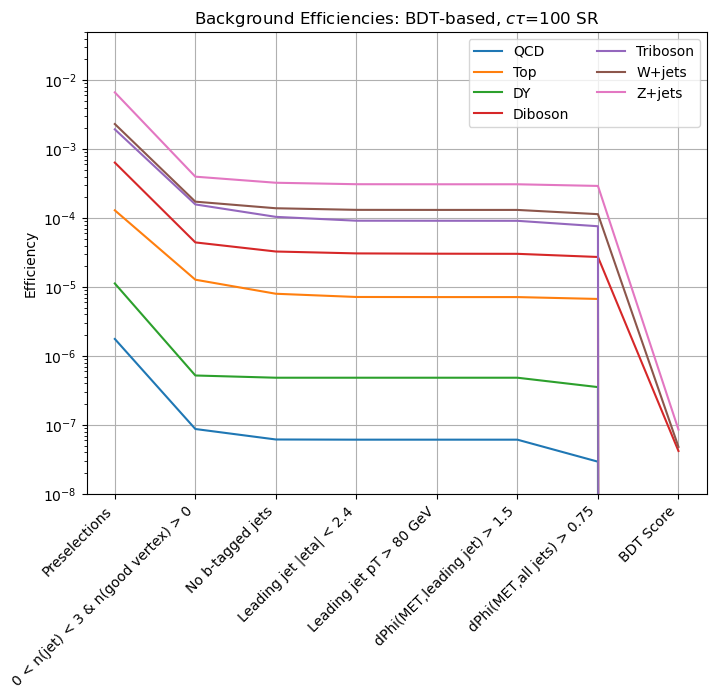

<Figure size 640x480 with 0 Axes>

In [142]:
# bkg efficiencies summed over sub-samples

plt.figure(figsize=(8,6))
plt.title(r"Background Efficiencies: BDT-based, $c\tau$=100 SR")

for b in bkg_histos.keys():
    cfbs = tot_bkg_effs[b]
    effs = [cfbs[c] for c in cuts]
    plt.plot(np.arange(len(effs)),effs,label=b)
    #plt.ylim([1e-12,1])

plt.yscale('log')
plt.ylabel("Efficiency")
plt.legend(loc='upper right',ncol=2)
plt.grid()

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
cut = list(map(lambda x: x.replace('BDT v2 Loose WP', 'BDT Score'), cut))
    
plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

plt.ylim([1e-8, 5e-2])
plt.show()

#os.makedirs("plots/cutflows/")
plt.savefig(f"plots/bkg_BDT-ctau1_combined_efficiencies.png")

### Bkg Yield

In [143]:
sqrtB = np.sqrt(bkg_cts_df.iloc[-1].loc['total'])

print('Total background after last SR cut: {:.2f}'.format(bkg_cts_df['total'].iloc[-1]))
print('sqrt(B) = {:.2f}'.format(sqrtB))

Total background after last SR cut: 6.86
sqrt(B) = 2.62


In [144]:
sqrtBs['100'] = sqrtB

### Signal Yield and Vtx Gen Matching Fraction

In [145]:
s_df = sig_cts_df.iloc[-1]
s_match_df = sig_match_df.iloc[-1]

# when only looking at the events where gen ee are reconstructed (dR(gen,reco)<0.1)
s_reco_df = sig_cts_reco_df.iloc[-1]
s_match_reco_df = sig_match_reco_df.iloc[-1]

In [146]:
columns_ctau = {'1': {'0p1': [], '0p2': []}, '10': {'0p1': [], '0p2': []}, '100': {'0p1': [], '0p2': []}}

for name in sig_columns:
    
    mchi = ptools.signalPoint(name)['mchi']
    dmchi = ptools.signalPoint(name)['dmchi']
    delta = ptools.signalPoint(name)['delta']

    if 'ctau-10' not in name:
        if delta == 0.1:
            columns_ctau['1']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['1']['0p2'].append(name)
    elif 'ctau-100' not in name:
        if delta == 0.1:
            columns_ctau['10']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['10']['0p2'].append(name)
    else:
        if delta == 0.1:
            columns_ctau['100']['0p1'].append(name)
        elif delta == 0.2:
            columns_ctau['100']['0p2'].append(name)

ct = '100'
delta = '0p1'
print(columns_ctau[ct][delta])

['sig_2018_Mchi-5p25_dMchi-0p5_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-100', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-100']


In [147]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['100']:
        signal_df[delta][ctau] = s_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_df[delta][ctau].rename(index = {signal_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_df[delta][ctau] = s_match_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_df[delta][ctau].rename(index = {signal_match_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [148]:
print('Signal yield for delta = 0.1, ctau = 100')
signal_df['0p1']['100'].transpose()

Signal yield for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,1.930462
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,2.084500
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,322.907075
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.864469
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.800294
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.915313


In [149]:
print('Vertex purity for delta = 0.1, ctau = 100')
signal_match_df['0p1']['100'].transpose()

Vertex purity for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,0.859860
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.929322
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.899046
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.960489
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.957745
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.913109


In [150]:
deltas = ['0p1','0p2']

for delta in deltas:
    for ctau in ['100']:
        signal_reco_df[delta][ctau] = s_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_reco_df[delta][ctau].rename(index = {signal_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

        signal_match_reco_df[delta][ctau] = s_match_reco_df.loc[columns_ctau[ctau][delta]].to_frame()[::-1].transpose()
        signal_match_reco_df[delta][ctau].rename(index = {signal_match_reco_df[delta][ctau].index[0]: f"{ctau}mm"}, inplace = True)

In [151]:
print('Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100')
signal_reco_df['0p1']['100'].transpose()

Signal yield when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,1.679269
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,1.986437
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,300.621085
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,1.817663
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.786222
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,1.790401


In [152]:
print('Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100')
signal_match_reco_df['0p1']['100'].transpose()

Vertex purity when only looking at events where gen ee are reconstructed; for delta = 0.1, ctau = 100


,100mm
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100,0.988481
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100,0.975199
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100,0.965695
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100,0.985222
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100,0.974888
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100,0.976814


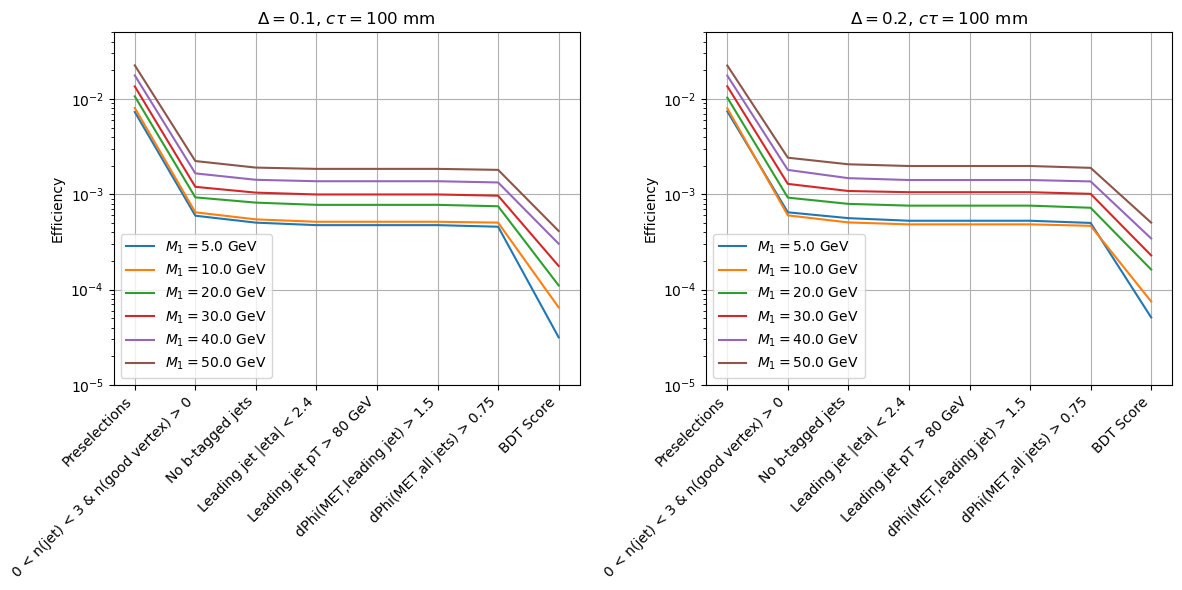

In [153]:
deltas = [0.1,0.2]

ct = 100

fig,axes = plt.subplots(1,len(deltas),figsize=(6*len(deltas),6))

for i, delta in enumerate(deltas):
    plt.sca(axes[i])
    plot_efficiency_signal_varying_M1( df_sig = si, dict_eff = cf_s, cuts = cuts, cutNames = cutNames, 
                                       delta = delta, ct = ct)
plt.tight_layout()
plt.show()

## Signal Yield for all ctaus

In [154]:
ctaus = ['1','10','100']

In [155]:
delta = '0p1'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_df[delta][ctau].columns]
    signal_df[delta][ctau].columns = m1s

    signal_df[delta][ctau] = signal_df[delta][ctau].sort_index(axis=1)

frames = [signal_df[delta]['1'], signal_df[delta]['10'], signal_df[delta]['100']]
delta_0p1_df = pd.concat(frames)

In [156]:
print('delta = 0p1, signal yield after last cut in SR')
delta_0p1_df

delta = 0p1, signal yield after last cut in SR


,5,10,20,30,40,50
1mm,2787.316093,1839.613547,1589.161260,1794.503944,990.728036,412.044822
10mm,84.007888,88.454491,96.233563,1171.794549,67.818152,27.287742
100mm,1.915313,1.930462,2.084500,322.907075,1.864469,0.800294


In [157]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_reco_df[delta][ctau].columns]
    signal_reco_df[delta][ctau].columns = m1s

    signal_reco_df[delta][ctau] = signal_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_reco_df[delta]['1'], signal_reco_df[delta]['10'], signal_reco_df[delta]['100']]
delta_0p1_reco_df = pd.concat(frames)

In [158]:
print('delta = 0p1, signal yield for events where gen ee are reconstructed, after last cut in SR')
delta_0p1_reco_df

delta = 0p1, signal yield for events where gen ee are reconstructed, after last cut in SR


,5,10,20,30,40,50
1mm,2787.316093,1807.605719,1571.503625,1777.665582,982.756605,408.001326
10mm,80.348722,86.209302,93.430809,1166.521911,66.908321,27.009639
100mm,1.790401,1.679269,1.986437,300.621085,1.817663,0.786222


In [159]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_df[delta][ctau].columns]
    signal_df[delta][ctau].columns = m1s

    signal_df[delta][ctau] = signal_df[delta][ctau].sort_index(axis=1)

frames = [signal_df[delta]['1'], signal_df[delta]['10'], signal_df[delta]['100']]
delta_0p2_df = pd.concat(frames)

In [160]:
print('delta = 0p2, signal yield after last cut in SR')
delta_0p2_df

delta = 0p2, signal yield after last cut in SR


,5,10,20,30,40,50
1mm,128.365134,79.588482,72.072975,4178.235083,38.762997,17.007244
10mm,4.543953,3.330175,4.041440,797.807828,2.603764,1.234690
100mm,0.098396,0.071560,0.096455,21.898237,0.065606,0.030711


In [161]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_reco_df[delta][ctau].columns]
    signal_reco_df[delta][ctau].columns = m1s

    signal_reco_df[delta][ctau] = signal_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_reco_df[delta]['1'], signal_reco_df[delta]['10'], signal_reco_df[delta]['100']]
delta_0p2_reco_df = pd.concat(frames)

In [162]:
print('delta = 0p2, signal yield for events where gen ee are reconstructed, after last cut in SR')
delta_0p2_reco_df

delta = 0p2, signal yield for events where gen ee are reconstructed, after last cut in SR


,5,10,20,30,40,50
1mm,127.074408,79.375994,71.933028,4124.890517,38.387746,16.736664
10mm,4.410148,3.296574,3.961948,795.806789,2.582899,1.224196
100mm,0.091868,0.066348,0.089574,20.913904,0.062436,0.030125


## Display S/B

In [163]:
pd.set_option("display.precision", 3)

In [164]:
delta = '0p1'

frames = [delta_0p1_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p1_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p1_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p1_SoverB_df = pd.concat(frames)

delta_0p1_SoverB_df = delta_0p1_SoverB_df.sort_index(axis=1)

In [165]:
print('delta = 0.1, S/sqrt(B)')

delta_0p1_SoverB_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_SoverB_df

delta = 0.1, S/sqrt(B)


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,493.296,325.573,281.248,317.589,175.338,72.923
10mm,28.923,30.454,33.132,403.432,23.349,9.395
100mm,0.731,0.737,0.796,123.322,0.712,0.306


In [166]:
delta = '0p1'

frames = [delta_0p1_reco_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p1_reco_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p1_reco_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p1_SoverB_reco_df = pd.concat(frames)

delta_0p1_SoverB_reco_df = delta_0p1_SoverB_reco_df.sort_index(axis=1)

print('delta = 0.1, S/sqrt(B), only counting the signal events where gen ee are reconstructed')

delta_0p1_SoverB_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_SoverB_reco_df

delta = 0.1, S/sqrt(B), only counting the signal events where gen ee are reconstructed


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,493.296,319.908,278.123,314.609,173.927,72.208
10mm,27.663,29.681,32.167,401.617,23.036,9.299
100mm,0.684,0.641,0.759,114.811,0.694,0.300


In [167]:
delta = '0p2'

frames = [delta_0p2_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p2_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p2_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p2_SoverB_df = pd.concat(frames)

delta_0p2_SoverB_df = delta_0p2_SoverB_df.sort_index(axis=1)

In [168]:
print('delta = 0.2, S/sqrt(B)')

delta_0p2_SoverB_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_SoverB_df

delta = 0.2, S/sqrt(B)


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,22.718,14.085,12.755,739.459,6.860,3.010
10mm,1.564,1.147,1.391,274.674,0.896,0.425
100mm,0.038,0.027,0.037,8.363,0.025,0.012


In [169]:
delta = '0p2'

frames = [delta_0p2_reco_df.iloc[0].to_frame().transpose()/sqrtBs['1'], \
          delta_0p2_reco_df.iloc[1].to_frame().transpose()/sqrtBs['10'], \
          delta_0p2_reco_df.iloc[2].to_frame().transpose()/sqrtBs['100']]

delta_0p2_SoverB_reco_df = pd.concat(frames)

delta_0p2_SoverB_reco_df = delta_0p2_SoverB_reco_df.sort_index(axis=1)

print('delta = 0.2, S/sqrt(B), only counting the signal events where gen ee are reconstructed')

delta_0p2_SoverB_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_SoverB_reco_df

delta = 0.2, S/sqrt(B), only counting the signal events where gen ee are reconstructed


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,22.489,14.048,12.731,730.018,6.794,2.962
10mm,1.518,1.135,1.364,273.985,0.889,0.421
100mm,0.035,0.025,0.034,7.987,0.024,0.012


In [170]:
ctaus = [1,10,100]

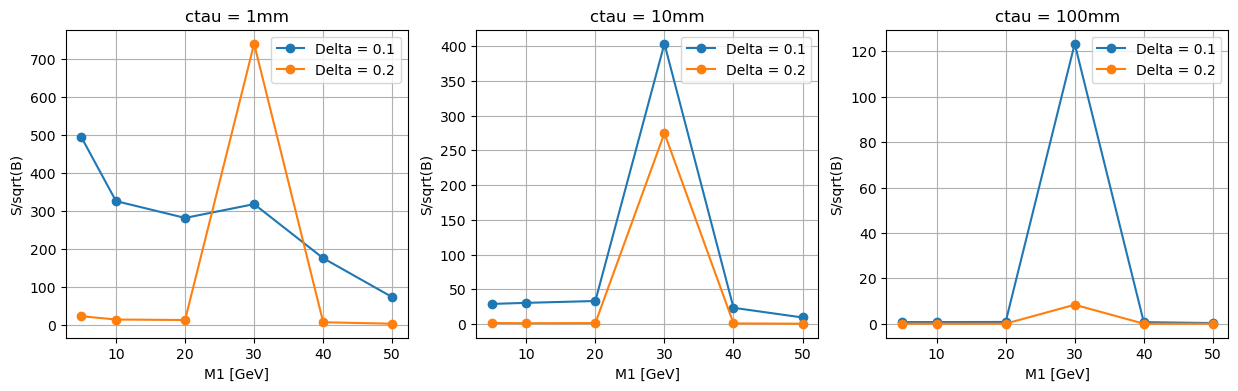

In [171]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_SoverB_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_SoverB_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'ctau = {ctau}mm')

## Vtx purity (fraction of events whose selected vertex is gen matched) for all ctaus

In [172]:
ctaus = ['1','10','100']

In [173]:
delta = '0p1'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_df[delta][ctau].columns]
    signal_match_df[delta][ctau].columns = m1s

    signal_match_df[delta][ctau] = signal_match_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_df[delta]['1'], signal_match_df[delta]['10'], signal_match_df[delta]['100']]
delta_0p1_match_df = pd.concat(frames)

In [174]:
print('BDTv2 SR')
print('delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]')

delta_0p1_match_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_match_df

BDTv2 SR
delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.975,0.951,0.967,0.968,0.971,0.975
10mm,0.884,0.959,0.942,0.975,0.973,0.978
100mm,0.913,0.860,0.929,0.899,0.960,0.958


In [175]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_reco_df[delta][ctau].columns]
    signal_match_reco_df[delta][ctau].columns = m1s

    signal_match_reco_df[delta][ctau] = signal_match_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_reco_df[delta]['1'], signal_match_reco_df[delta]['10'], signal_match_reco_df[delta]['100']]
delta_0p1_match_reco_df = pd.concat(frames)

In [176]:
print('BDTv2 SR')
print('delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]')
delta_0p1_match_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p1_match_reco_df

BDTv2 SR
delta = 0.1, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.975,0.968,0.978,0.977,0.979,0.985
10mm,0.924,0.984,0.970,0.980,0.986,0.988
100mm,0.977,0.988,0.975,0.966,0.985,0.975


In [177]:
delta = '0p2'

for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_df[delta][ctau].columns]
    signal_match_df[delta][ctau].columns = m1s

    signal_match_df[delta][ctau] = signal_match_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_df[delta]['1'], signal_match_df[delta]['10'], signal_match_df[delta]['100']]
delta_0p2_match_df = pd.concat(frames)

In [178]:
print('BDTv2 SR')
print('delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]')

delta_0p2_match_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_match_df

BDTv2 SR
delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(all)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.980,0.971,0.973,0.970,0.981,0.984
10mm,0.941,0.970,0.966,0.987,0.976,0.987
100mm,0.934,0.909,0.918,0.910,0.942,0.955


In [179]:
for idx, ctau in enumerate(ctaus):
    m1s = [int(ptools.signalPoint(i)['m1']) for i in signal_match_reco_df[delta][ctau].columns]
    signal_match_reco_df[delta][ctau].columns = m1s

    signal_match_reco_df[delta][ctau] = signal_match_reco_df[delta][ctau].sort_index(axis=1)

frames = [signal_match_reco_df[delta]['1'], signal_match_reco_df[delta]['10'], signal_match_reco_df[delta]['100']]
delta_0p2_match_reco_df = pd.concat(frames)

In [180]:
print('BDTv2 SR')
print('delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]')
delta_0p2_match_reco_df.columns = [f'{m1} GeV' for m1 in sorted(m1s)]

delta_0p2_match_reco_df

BDTv2 SR
delta = 0.2, vertex purity = [nEvents(best vertex matches the true vertex)] / [nEvents(having gen ee reconstructed)]


,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
1mm,0.99,0.973,0.975,0.983,0.990,1.000
10mm,0.97,0.980,0.986,0.990,0.984,0.996
100mm,1.00,0.980,0.989,0.953,0.990,0.974


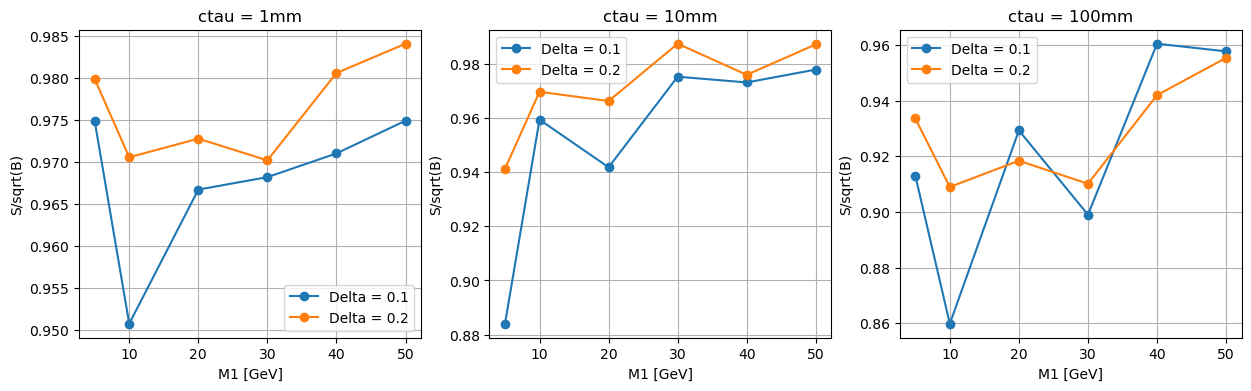

In [181]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_match_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_match_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'ctau = {ctau}mm')

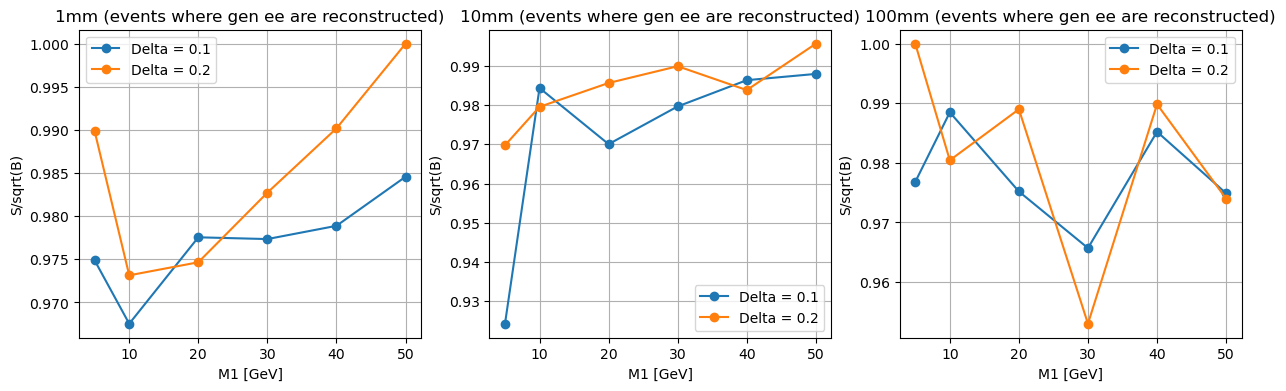

In [182]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, ctau in enumerate(ctaus):
    ctau = int(ctau)
    
    y_arr_1 = delta_0p1_match_reco_df.iloc[idx].to_list()
    y_arr_2 = delta_0p2_match_reco_df.iloc[idx].to_list()

    x_arr = sorted(m1s)
    
    axes[idx].plot(x_arr, y_arr_1, '-o', label=f'Delta = 0.1')
    axes[idx].plot(x_arr, y_arr_2, '-o', label=f'Delta = 0.2')

    axes[idx].legend()
    
    axes[idx].set_xlabel('M1 [GeV]')
    axes[idx].set_ylabel('S/sqrt(B)')
    
    axes[idx].grid()
    
    axes[idx].set_title(f'{ctau}mm (events where gen ee are reconstructed)')

In [183]:
# export
delta_0p1_SoverB_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p1.csv')
delta_0p2_SoverB_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p2.csv') 

# export
delta_0p1_SoverB_reco_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p1_hasGenEEreconstructed.csv')
delta_0p2_SoverB_reco_df.to_csv('../BDTv2-based-SR_SoverB_delta_0p2_hasGenEEreconstructed.csv') 

In [184]:
# export
delta_0p1_match_df.to_csv('../BDTv2-based-SR_Purity_delta_0p1.csv') 
delta_0p2_match_df.to_csv('../BDTv2-based-SR_Purity_delta_0p2.csv') 

delta_0p1_match_reco_df.to_csv('../BDTv2-based-SR_Purity_delta_0p1_hasGenEEreconstructed.csv') 
delta_0p2_match_reco_df.to_csv('../BDTv2-based-SR_Purity_delta_0p2_hasGenEEreconstructed.csv') 

In [185]:
bYields = {}

for bkg in sqrtBs.keys():
    bYields[bkg] = sqrtBs[bkg]**2

pd.DataFrame.from_dict(bYields, orient='index')

,0
1,31.927
10,8.437
100,6.856


## Compare S/B with Other SR

In [186]:
s_over_b = {'Cut': {}, 'BDTv2': {}}

for typ in s_over_b.keys():
    for delta in ['0p1','0p2']:
        with open(f'../{typ}-based-SR_SoverB_delta_{delta}.csv') as x:
            ncols = len(x.readline().split(','))
        
        s_over_b[typ][delta] = pd.read_csv(f'../{typ}-based-SR_SoverB_delta_{delta}.csv', usecols=range(1,ncols))

In [187]:
s_over_b['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,133.384,89.330,81.494,87.321,48.133,19.279
1,8.430,7.869,7.547,87.802,5.045,1.873
2,0.164,0.145,0.155,23.922,0.140,0.060


In [188]:
s_over_b['BDTv2']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,493.296,325.573,281.248,317.589,175.338,72.923
1,28.923,30.454,33.132,403.432,23.349,9.395
2,0.731,0.737,0.796,123.322,0.712,0.306


In [189]:
s_over_b['BDTv2']['0p1']/s_over_b['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,3.698,3.645,3.451,3.637,3.643,3.783
1,3.431,3.870,4.390,4.595,4.628,5.017
2,4.467,5.079,5.134,5.155,5.090,5.076


In [190]:
s_over_b['BDTv2']['0p2']/s_over_b['Cut']['0p2']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,3.432,3.511,3.547,3.982,3.914,3.725
1,4.149,4.863,4.733,4.829,5.477,5.774
2,4.791,4.913,5.276,4.677,5.346,6.264


In [191]:
ratio = {'BDTv2': {}}

for typ in ratio.keys():
    for delta in ['0p1','0p2']:
        ratio[typ][delta] = s_over_b[typ][delta]/s_over_b['Cut'][delta]

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 1mm')

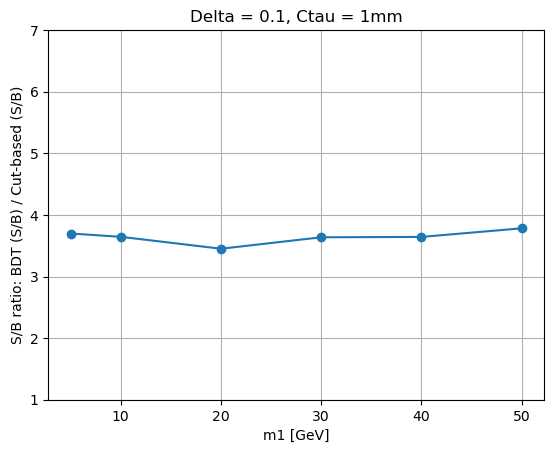

In [192]:
# ctau-1, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
#y_arr1 = ratio['BDTv1']['0p1'].iloc[0].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p1'].iloc[0].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
#plt.plot(x_arr2, y_arr2, 'o-', label='BDT')
plt.plot(x_arr2, y_arr2, 'o-')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
#plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 10mm')

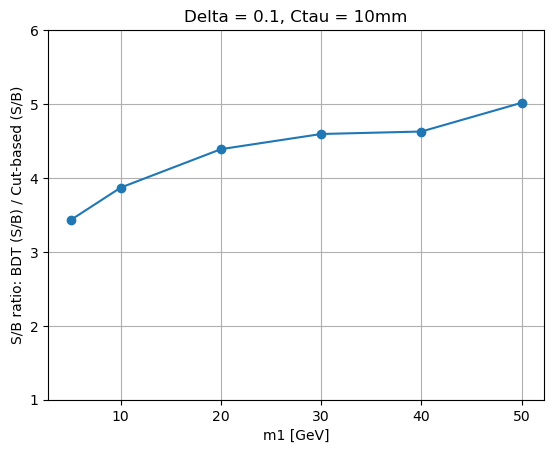

In [193]:
# ctau-1, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
#y_arr1 = ratio['BDTv1']['0p1'].iloc[1].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p1'].iloc[1].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
#plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')
plt.plot(x_arr2, y_arr2, 'o-')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,6])
#plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.1, Ctau = 100mm')

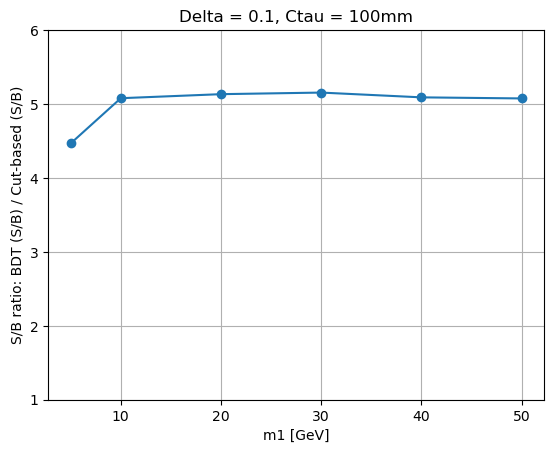

In [194]:
# ctau-100, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
#y_arr1 = ratio['BDTv1']['0p1'].iloc[2].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p1'].iloc[2].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
#plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')
plt.plot(x_arr2, y_arr2, 'o-')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,6])
#plt.legend()

plt.grid()

plt.title('Delta = 0.1, Ctau = 100mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 1mm')

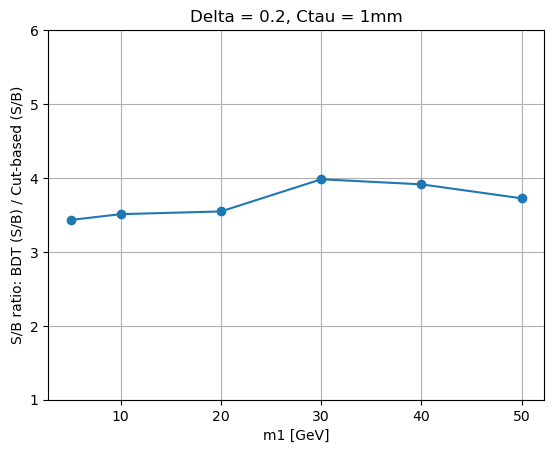

In [195]:
# ctau-1, delta 0.2

#x_arr1 = [5,10,20,30,50]
x_arr2 = [5,10,20,30,40,50]
#y_arr1 = ratio['BDTv1']['0p2'].iloc[0].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p2'].iloc[0].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
#plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')
plt.plot(x_arr2, y_arr2, 'o-')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,6])
#plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 1mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 10mm')

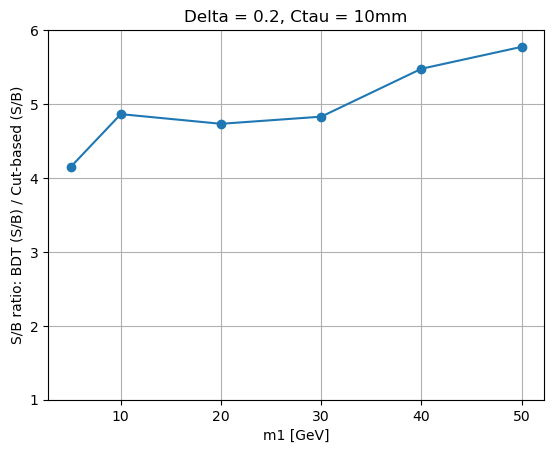

In [196]:
# ctau-1, delta 0.2

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
#y_arr1 = ratio['BDTv1']['0p2'].iloc[1].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p2'].iloc[1].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
#plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')
plt.plot(x_arr2, y_arr2, 'o-')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,6])
#plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 10mm')

Text(0.5, 1.0, 'Delta = 0.2, Ctau = 100mm')

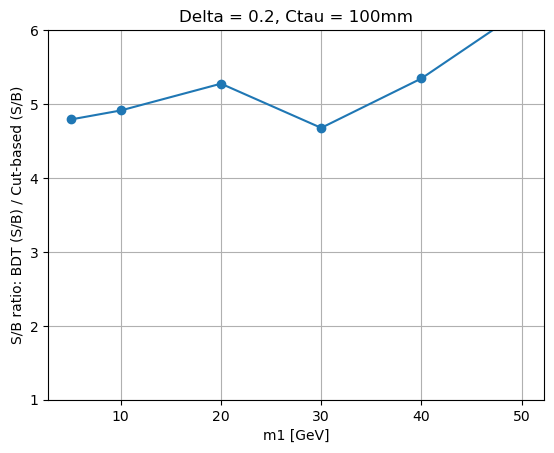

In [197]:
# ctau-100, delta 0.2

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
#y_arr1 = ratio['BDTv1']['0p2'].iloc[2].dropna().to_list()
y_arr2 = ratio['BDTv2']['0p2'].iloc[2].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1')
#plt.plot(x_arr2, y_arr2, 'o-', label='BDTv2')

plt.plot(x_arr2, y_arr2, 'o-')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,6])
#plt.legend()

plt.grid()

plt.title('Delta = 0.2, Ctau = 100mm')

Text(0.5, 1.0, 'c$\\tau$ = 1mm')

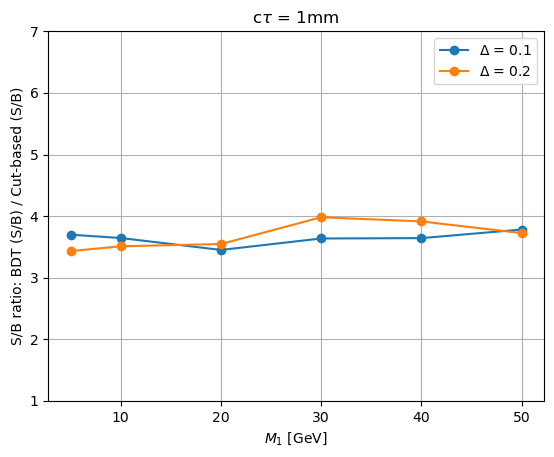

In [198]:
# ctau-1

x_arr1 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv2']['0p1'].iloc[0].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label=r'$\Delta$ = 0.1')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

x_arr2 = [5,10,20,30,40,50]
y_arr2 = ratio['BDTv2']['0p2'].iloc[0].dropna().to_list()

plt.plot(x_arr2, y_arr2, 'o-', label=r'$\Delta$ = 0.2')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title(r'c$\tau$ = 1mm')

Text(0.5, 1.0, 'c$\\tau$ = 10mm')

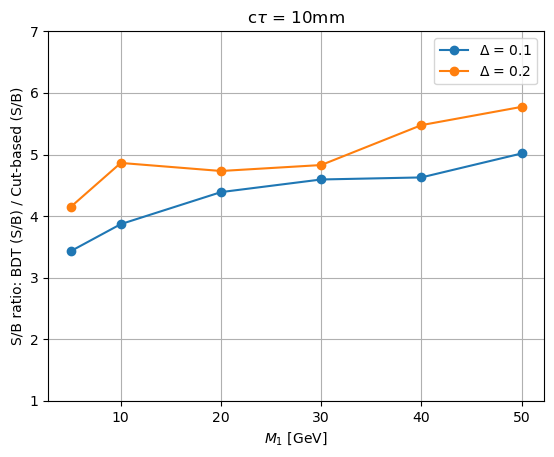

In [199]:
# ctau-1

x_arr1 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv2']['0p1'].iloc[1].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label=r'$\Delta$ = 0.1')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

x_arr2 = [5,10,20,30,40,50]
y_arr2 = ratio['BDTv2']['0p2'].iloc[1].dropna().to_list()

plt.plot(x_arr2, y_arr2, 'o-', label=r'$\Delta$ = 0.2')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title(r'c$\tau$ = 10mm')

Text(0.5, 1.0, 'c$\\tau$ = 100mm')

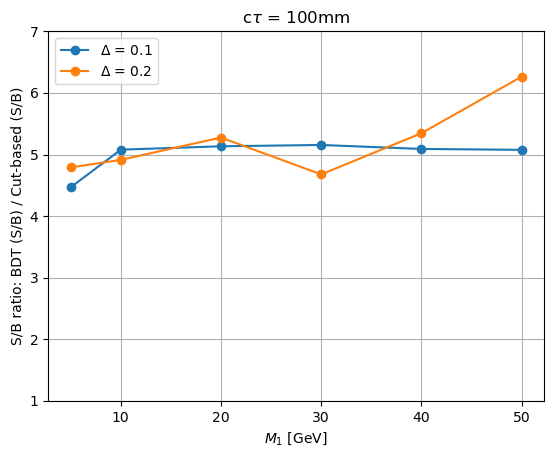

In [200]:
# ctau-1

x_arr1 = [5,10,20,30,40,50]
y_arr1 = ratio['BDTv2']['0p1'].iloc[2].dropna().to_list()

plt.plot(x_arr1, y_arr1, 'o-', label=r'$\Delta$ = 0.1')

plt.xlabel('m1 [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

x_arr2 = [5,10,20,30,40,50]
y_arr2 = ratio['BDTv2']['0p2'].iloc[2].dropna().to_list()

plt.plot(x_arr2, y_arr2, 'o-', label=r'$\Delta$ = 0.2')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('S/B ratio: BDT (S/B) / Cut-based (S/B)')

plt.ylim([1,7])
plt.legend()

plt.grid()

plt.title(r'c$\tau$ = 100mm')

## Compare Vertex Purity with other SR

In [201]:
purity = {'Cut': {}, 'BDTv2': {}}

for typ in s_over_b.keys():
    for delta in ['0p1','0p2']:
        with open(f'../{typ}-based-SR_Purity_delta_{delta}.csv') as x:
            ncols = len(x.readline().split(','))
        
        purity[typ][delta] = pd.read_csv(f'../{typ}-based-SR_Purity_delta_{delta}.csv', usecols=range(1,ncols))

In [202]:
purity['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,0.966,0.934,0.967,0.961,0.949,0.956
1,0.901,0.941,0.947,0.969,0.977,0.970
2,0.870,0.864,0.932,0.877,0.955,0.916


Text(0.5, 1.0, '$\\Delta$ = 0.1, c$\\tau$ = 1mm')

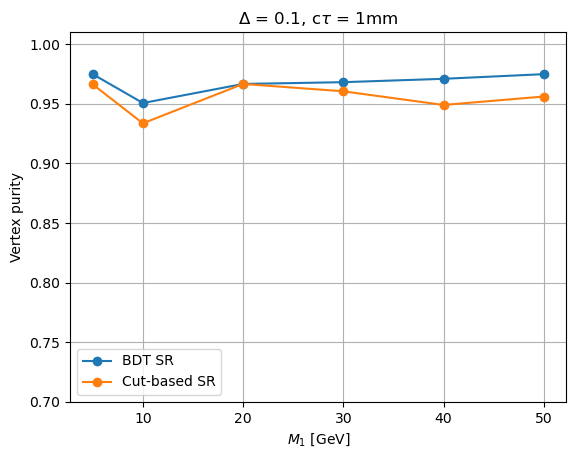

In [203]:
# ctau-1, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p1'].iloc[0].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[0].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[0].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.1, c$\tau$ = 1mm')

Text(0.5, 1.0, '$\\Delta$ = 0.1, c$\\tau$ = 10mm')

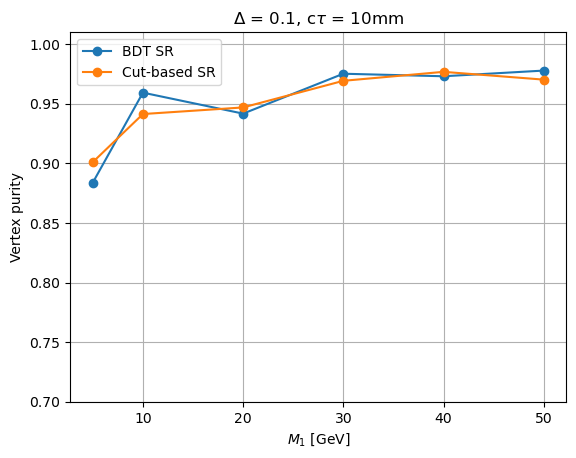

In [204]:
# ctau-10, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p1'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[1].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.1, c$\tau$ = 10mm')

Text(0.5, 1.0, '$\\Delta$ = 0.1, c$\\tau$ = 100mm')

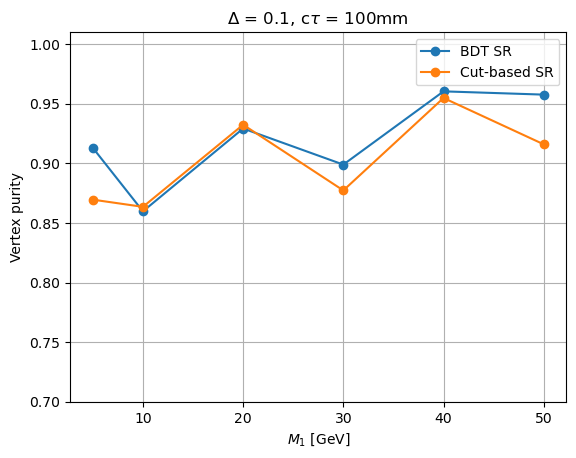

In [205]:
# ctau-100, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p1'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[2].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.1, c$\tau$ = 100mm')

Text(0.5, 1.0, '$\\Delta$ = 0.2, c$\\tau$ = 1mm')

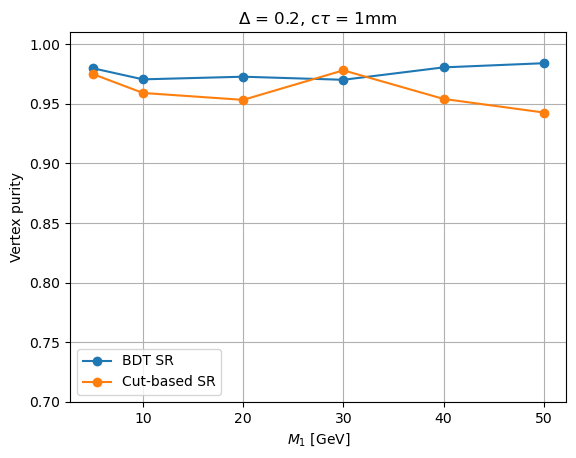

In [206]:
# ctau-1, delta 0.2

#x_arr1 = [5,10,20,30,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = (purity['BDTv1']['0p2'].iloc[0])[purity['BDTv1']['0p2'].iloc[0] != 0].to_list()
y_arr2 = (purity['BDTv2']['0p2'].iloc[0])[purity['BDTv2']['0p2'].iloc[0] != 0].to_list()
y_arr3 = (purity['Cut']['0p2'].iloc[0])[purity['Cut']['0p2'].iloc[0] != 0].to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.2, c$\tau$ = 1mm')

Text(0.5, 1.0, '$\\Delta$ = 0.2, c$\\tau$ = 10mm')

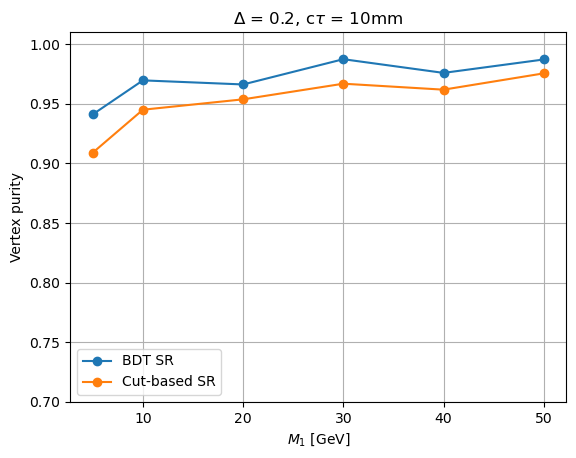

In [207]:
# ctau-10, delta 0.2

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p2'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[1].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.2, c$\tau$ = 10mm')

Text(0.5, 1.0, '$\\Delta$ = 0.2, c$\\tau$ = 100mm')

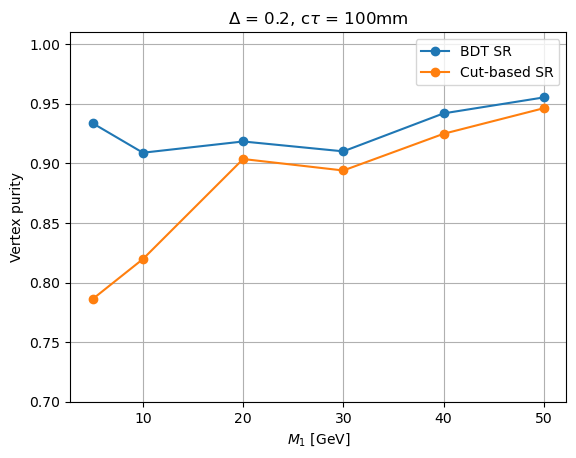

In [208]:
# ctau-100, delta 0.2

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p2'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[2].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.2, c$\tau$ = 100mm')

## Compare vertex purity with other SR: only counting the ones where the gen ee are reconstructed

In [209]:
purity = {'Cut': {}, 'BDTv2': {}}

for typ in s_over_b.keys():
    for delta in ['0p1','0p2']:
        with open(f'../{typ}-based-SR_Purity_delta_{delta}_hasGenEEreconstructed.csv') as x:
            ncols = len(x.readline().split(','))
        
        purity[typ][delta] = pd.read_csv(f'../{typ}-based-SR_Purity_delta_{delta}_hasGenEEreconstructed.csv', usecols=range(1,ncols))

In [210]:
purity['Cut']['0p1']

,5 GeV,10 GeV,20 GeV,30 GeV,40 GeV,50 GeV
0,0.966,0.958,0.967,0.97,0.965,0.972
1,0.948,0.960,0.973,0.99,0.992,0.985
2,0.930,0.974,0.972,0.96,0.987,0.958


Text(0.5, 1.0, '$\\Delta$ = 0.1, c$\\tau$ = 1mm')

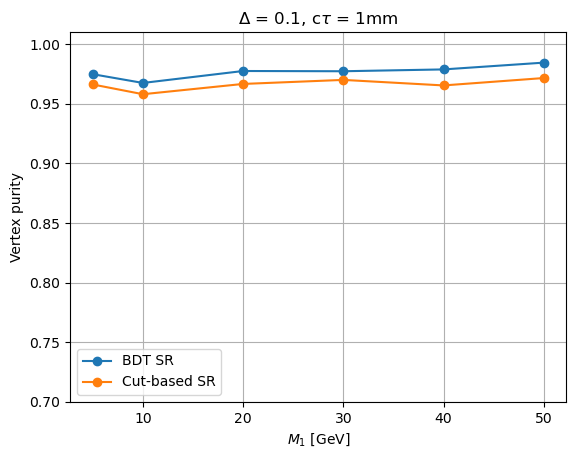

In [211]:
# ctau-1, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p1'].iloc[0].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[0].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[0].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.1, c$\tau$ = 1mm')

Text(0.5, 1.0, '$\\Delta$ = 0.1, c$\\tau$ = 10mm')

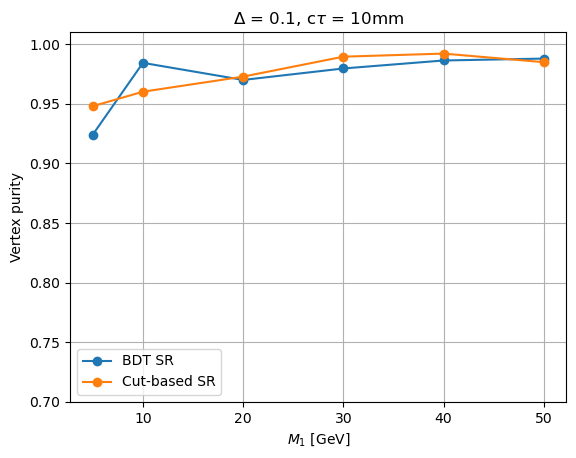

In [212]:
# ctau-10, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p1'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[1].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.1, c$\tau$ = 10mm')

Text(0.5, 1.0, '$\\Delta$ = 0.1, c$\\tau$ = 100mm')

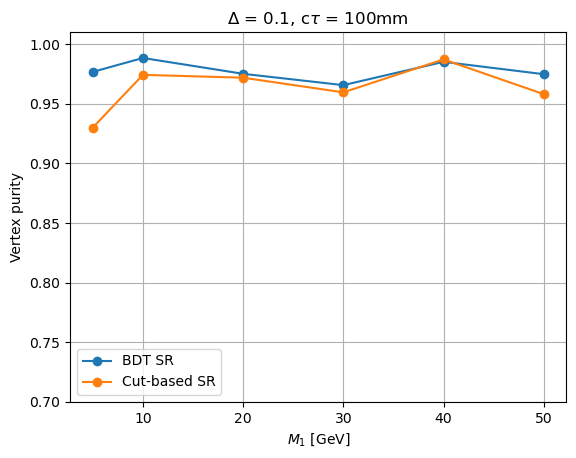

In [213]:
# ctau-100, delta 0.1

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p1'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p1'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p1'].iloc[2].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.1, c$\tau$ = 100mm')

Text(0.5, 1.0, '$\\Delta$ = 0.2, c$\\tau$ = 1mm')

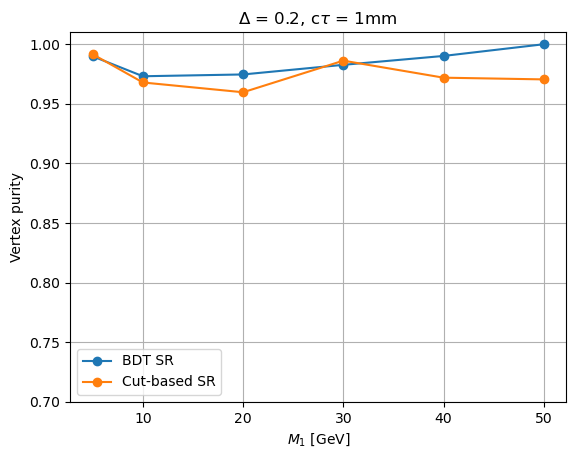

In [214]:
# ctau-1, delta 0.2

#x_arr1 = [5,10,20,30,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = (purity['BDTv1']['0p2'].iloc[0])[purity['BDTv1']['0p2'].iloc[0] != 0].to_list()
y_arr2 = (purity['BDTv2']['0p2'].iloc[0])[purity['BDTv2']['0p2'].iloc[0] != 0].to_list()
y_arr3 = (purity['Cut']['0p2'].iloc[0])[purity['Cut']['0p2'].iloc[0] != 0].to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.2, c$\tau$ = 1mm')

Text(0.5, 1.0, '$\\Delta$ = 0.2, c$\\tau$ = 10mm')

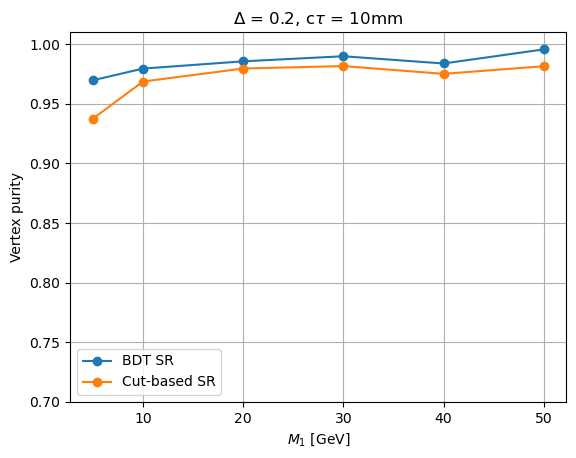

In [215]:
# ctau-10, delta 0.2

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p2'].iloc[1].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[1].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[1].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.2, c$\tau$ = 10mm')

Text(0.5, 1.0, '$\\Delta$ = 0.2, c$\\tau$ = 100mm')

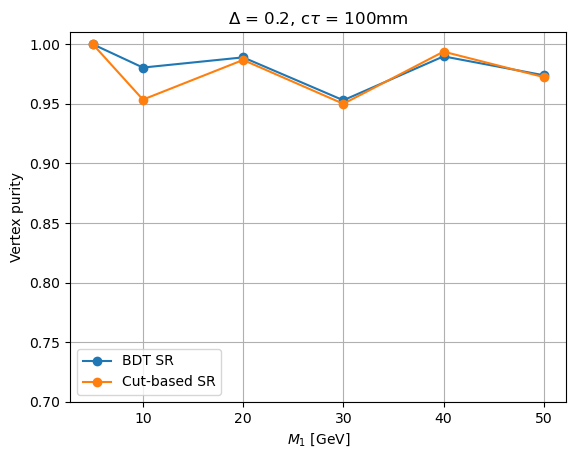

In [216]:
# ctau-100, delta 0.2

#x_arr1 = [5,10,20,30,40,50]
x_arr2 = [5,10,20,30,40,50]
x_arr3 = [5,10,20,30,40,50]

#y_arr1 = purity['BDTv1']['0p2'].iloc[2].dropna().to_list()
y_arr2 = purity['BDTv2']['0p2'].iloc[2].dropna().to_list()
y_arr3 = purity['Cut']['0p2'].iloc[2].dropna().to_list()

#plt.plot(x_arr1, y_arr1, 'o-', label='BDTv1 SR')
plt.plot(x_arr2, y_arr2, 'o-', label='BDT SR')
plt.plot(x_arr3, y_arr3, 'o-', label='Cut-based SR')

plt.xlabel(r'$M_{1}$ [GeV]')
plt.ylabel('Vertex purity')

plt.ylim([0.7,1.01])
plt.legend()

plt.grid()

plt.title(r'$\Delta$ = 0.2, c$\tau$ = 100mm')